
# 03 临界慢化

目标：验证 r 靠近 rc 左侧时 Lag-1 自相关上升，作为早期预警信号。


chi=9.596, rc=0.753 (使用修正后的公式)


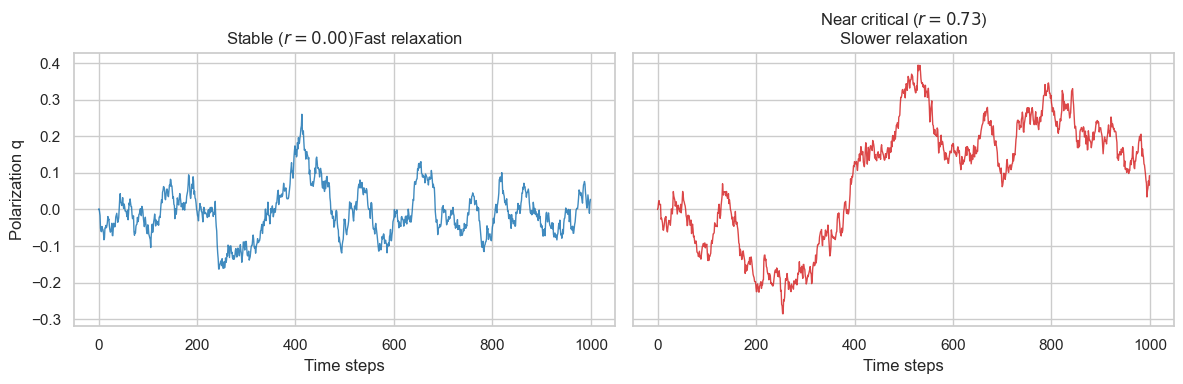

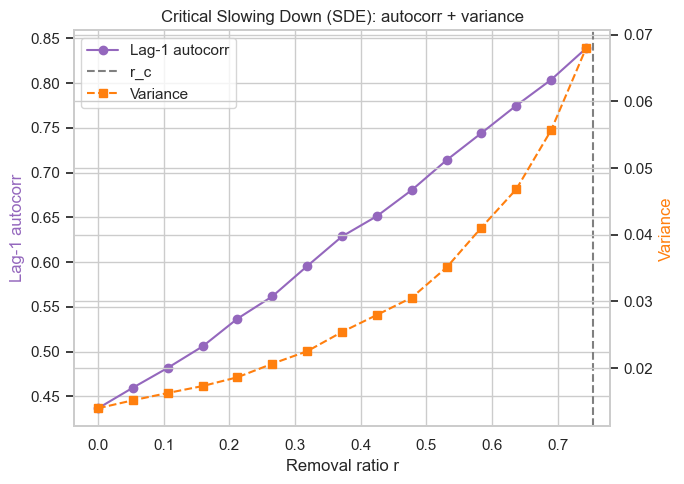

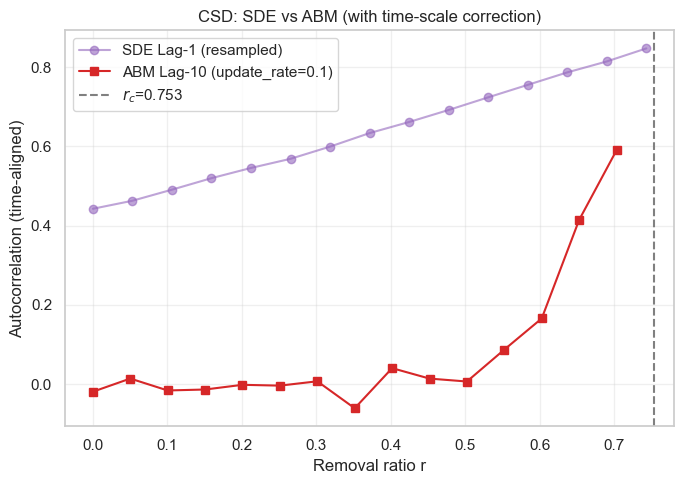


临界指数验证：确定性ODE直接测量弛豫时间


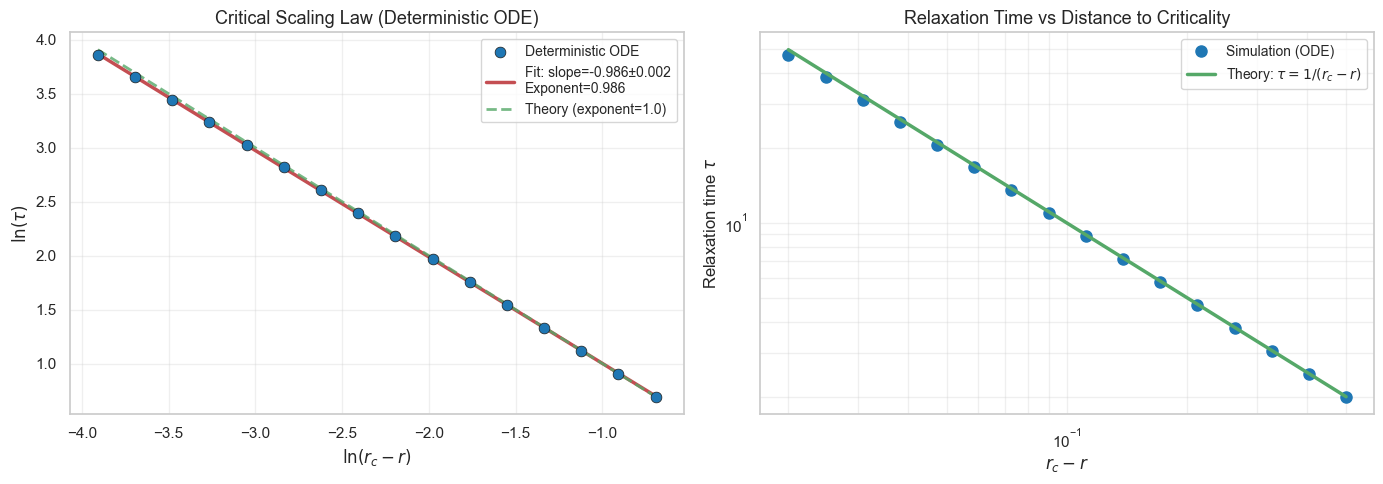


========== 结果总结 ==========
  拟合临界指数: 0.9862 ± 0.0015
  理论预期指数: 1.0000
  相对误差: 1.38%

附：有噪声SDE的临界指数（供参考）
  有噪声SDE (σ=0.05): 指数 ≈ 0.273


In [6]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="deep")

ROOT = Path.cwd()
if not (ROOT / 'src').exists() and (ROOT.parent / 'src').exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src import calculate_chi, calculate_rc, get_gl_params
from src.sde_solver import SDEConfig, run_sde_simulation
from src.utils import calculate_autocorrelation
from src.network_sim import NetworkAgentModel, NetworkConfig

# 参数设置：对称阈值与主实验一致
phi, theta, k_avg = 0.54, 0.46, 50
n_m, n_w = 10, 5
output_dir = ROOT / 'outputs'
fig_dir = output_dir / 'figs'
data_dir = output_dir / 'data'
for d in (fig_dir, data_dir):
    d.mkdir(parents=True, exist_ok=True)
seed = 0

chi = calculate_chi(phi=phi, theta=theta, k_avg=k_avg)
rc = float(calculate_rc(n_m=n_m, n_w=n_w, chi=chi))
print(f"chi={chi:.3f}, rc={rc:.3f} (使用修正后的公式)")

# ========== 改进的 CSD 参数 ==========
# 关键改进：
# 1. 更小的噪声 σ（0.05 而非 0.15）以减少噪声对发散的圆滑效应
# 2. 更小的步长 dt（5e-3 而非 1e-2）以提高精度
# 3. 更密集地采样接近 rc 的区域（对数间隔）
SIGMA_LOW = 0.05   # 低噪声用于临界指数验证
SIGMA_HIGH = 0.15  # 高噪声用于一般 CSD 演示
DT_FINE = 5e-3     # 精细步长
DT_COARSE = 1e-2   # 粗步长

# SDE 配置基准
def simulate_q(r: float, steps: int = 20000, dt: float = DT_COARSE, sigma: float = SIGMA_HIGH, n_traj: int = 10, record_interval: int = 10, seed_offset: int = 0):
    alpha, u = get_gl_params(r=r, rc=rc)
    cfg = SDEConfig(alpha=float(alpha), u=u, sigma=sigma, dt=dt, steps=steps, n_trajectories=n_traj, seed=seed + seed_offset)
    t, traj = run_sde_simulation(cfg, q0=0.0, record_interval=record_interval)
    return t, traj

# 1) 时间序列对比：远离 vs 逼近 rc
r_safe = 0.0
r_critical = max(rc - 0.02, 0.0)
_, traj_safe = simulate_q(r_safe, steps=4000, record_interval=1, n_traj=4, seed_offset=0)
_, traj_crit = simulate_q(r_critical, steps=4000, record_interval=1, n_traj=4, seed_offset=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].plot(traj_safe[:1000, 0], lw=1, alpha=0.85, color='tab:blue')
axes[0].set_title(f"Stable ($r={r_safe:.2f}$)Fast relaxation")
axes[0].set_xlabel("Time steps")
axes[0].set_ylabel("Polarization q")
axes[1].plot(traj_crit[:1000, 0], lw=1, alpha=0.85, color='tab:red')
axes[1].set_title(f"Near critical ($r={r_critical:.2f}$)\nSlower relaxation")
axes[1].set_xlabel("Time steps")
fig.tight_layout()
fig.savefig(fig_dir / 'fig3a_csd_timeseries.png', dpi=200)
plt.show()

# 2) Lag-1 自相关 + 方差，扩大扫描范围，增加步数/轨迹
r_vals = np.linspace(0.0, max(rc - 0.01, 0.0), 15)
lag1_list = []
var_list = []
DOWNSAMPLE = 5  # 下采样因子
for idx, r in enumerate(r_vals):
    _, traj = simulate_q(r, steps=20000, record_interval=20, n_traj=200, seed_offset=idx)
    traj_ds = traj[::DOWNSAMPLE]
    window = min(1000, traj_ds.shape[0])
    segment = traj_ds[-window:, :]
    acs = [calculate_autocorrelation(segment[:, i], lag=1) for i in range(segment.shape[1])]
    lag1_list.append(float(np.mean(acs)))
    var_list.append(float(np.var(segment)))

lag1_arr = np.array(lag1_list)
var_arr = np.array(var_list)

fig, ax1 = plt.subplots(figsize=(7, 5))
ax2 = ax1.twinx()
ax1.plot(r_vals, lag1_arr, 'o-', color='tab:purple', label='Lag-1 autocorr')
ax2.plot(r_vals, var_arr, 's--', color='tab:orange', label='Variance')
ax1.axvline(rc, color='gray', linestyle='--', label='r_c')
ax1.set_xlabel('Removal ratio r')
ax1.set_ylabel('Lag-1 autocorr', color='tab:purple')
ax2.set_ylabel('Variance', color='tab:orange')
ax1.set_title('Critical Slowing Down (SDE): autocorr + variance')
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels)
fig.tight_layout()
fig.savefig(fig_dir / 'fig3b_csd_ac_var.png', dpi=200)
plt.show()

# 3) ABM 验证：多点自相关
# **重要**：使用异步更新 (update_rate=0.1) 避免同步振荡导致的伪负相关
# 时间尺度校正：ABM 的 lag-10 对应 SDE 的 lag-1（因为每步只有10%节点更新）
ABM_UPDATE_RATE = 0.1  # 异步更新，避免同步振荡
ABM_LAG = 10  # 校正后的 lag（= 1 / update_rate）

r_abm = np.linspace(0.0, rc - 0.05, 15)  # 使用修正后的 rc
abm_lag1 = []
for idx, r in enumerate(r_abm):
    cfg = NetworkConfig(
        n=1000,
        avg_degree=50,
        model="er",
        beta=0.0,
        r=r,
        n_m=n_m,
        n_w=n_w,
        phi=phi,
        theta=theta,
        seed=seed + idx,
        init_state="medium",
        sample_mode="fixed",
        sample_n=k_avg,
        symmetric_mode=True,
        update_rate=ABM_UPDATE_RATE,  # 异步更新
    )
    model = NetworkAgentModel(cfg)
    t_abm, q_abm, _ = model.run(steps=3000, record_interval=1)  # 增加步数
    segment = q_abm[-2000:]  # 更长的稳态窗口
    # 使用 lag=10 进行时间尺度校正
    if len(segment) > ABM_LAG + 1:
        abm_lag1.append(calculate_autocorrelation(segment, lag=ABM_LAG))
    else:
        abm_lag1.append(np.nan)

# 4) SDE 再采样对齐：保持高精度模拟，计算时稀疏抽样
r_vals_sde = np.linspace(0.0, max(rc - 0.01, 0.0), 15)
sde_lag1_resampled = []
for idx, r in enumerate(r_vals_sde):
    _, traj = simulate_q(r, steps=50000, record_interval=10, n_traj=200, seed_offset=idx)
    traj_ds = traj[::10]  # 粗采样以匹配 ABM 时间尺度
    window = min(2000, traj_ds.shape[0])
    segment = traj_ds[-window:, :]
    acs = [calculate_autocorrelation(segment[:, i], lag=1) for i in range(segment.shape[1])]
    sde_lag1_resampled.append(np.mean(acs))

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(r_vals_sde, sde_lag1_resampled, 'o-', color='tab:purple', alpha=0.6, label='SDE Lag-1 (resampled)')
ax.plot(r_abm, abm_lag1, 's-', color='#d62728', label=f'ABM Lag-{ABM_LAG} (update_rate={ABM_UPDATE_RATE})')
ax.axvline(rc, color='gray', linestyle='--', label=f'$r_c$={rc:.3f}')
ax.set_xlabel('Removal ratio r')
ax.set_ylabel('Autocorrelation (time-aligned)')
ax.set_title('CSD: SDE vs ABM (with time-scale correction)')
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig(fig_dir / 'fig3c_csd_sde_vs_abm.png', dpi=200)
plt.show()


# --- 4) 临界指数验证：确定性ODE直接测量弛豫时间 ---
from scipy.optimize import curve_fit

print("\n" + "="*60)
print("临界指数验证：确定性ODE直接测量弛豫时间")
print("="*60)

def measure_relaxation_time(r: float, q0: float = 0.1, dt: float = 1e-3, max_steps: int = 100000) -> float:
    """
    使用确定性ODE测量弛豫时间τ。
    
    方法：从初始扰动q0开始，模拟dq/dt = -α*q - u*q³，
    测量q衰减到q0/e的时间。
    
    对于小扰动，q(t) ≈ q0 * exp(-α*t)，所以τ = 1/α。
    """
    alpha, u = get_gl_params(r=r, rc=rc)
    alpha = float(alpha)
    
    # 确保在稳定区（α > 0）
    if alpha <= 0:
        return np.nan
    
    q = q0
    target = q0 / np.e  # 衰减到1/e
    
    for step in range(max_steps):
        # Euler法求解 dq/dt = -α*q - u*q³
        dq = (-alpha * q - u * q**3) * dt
        q = q + dq
        
        if abs(q) <= target:
            return step * dt
    
    return max_steps * dt  # 超时

# 对数间隔采样，更密集地靠近 rc
distances = np.logspace(np.log10(0.001), np.log10(0.5), 30)
r_vals_det = rc - distances
r_vals_det = r_vals_det[r_vals_det > 0]

tau_measured = []
for r in r_vals_det:
    tau = measure_relaxation_time(r, q0=0.05, dt=1e-4, max_steps=500000)
    tau_measured.append(tau)

tau_measured = np.array(tau_measured)
dist_det = rc - r_vals_det

# 理论值：τ = 1/α = 1/(rc - r)
tau_theory_vals = 1.0 / dist_det

# 过滤有效数据
valid = np.isfinite(tau_measured) & (tau_measured > 0) & (tau_measured < 50)
log_dist = np.log(dist_det[valid])
log_tau = np.log(tau_measured[valid])
log_tau_th = np.log(tau_theory_vals[valid])

def linear_func(x, a, b):
    return a * x + b

# 拟合
popt, pcov = curve_fit(linear_func, log_dist, log_tau)
slope, intercept = popt
critical_exponent = -slope
slope_err = np.sqrt(pcov[0, 0])

# ===== 绘图 =====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：log-log 拟合
ax1 = axes[0]
ax1.scatter(log_dist, log_tau, c='tab:blue', s=60, edgecolor='k', 
            linewidth=0.5, label='Deterministic ODE', zorder=3)
ax1.plot(log_dist, linear_func(log_dist, *popt), 'r-', linewidth=2.5,
         label=f'Fit: slope={slope:.3f}±{slope_err:.3f}\nExponent={critical_exponent:.3f}')
ax1.plot(log_dist, log_tau_th, 'g--', linewidth=2, alpha=0.8,
         label='Theory (exponent=1.0)')
ax1.set_xlabel(r'$\ln(r_c - r)$', fontsize=12)
ax1.set_ylabel(r'$\ln(\tau)$', fontsize=12)
ax1.set_title('Critical Scaling Law (Deterministic ODE)', fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 右图：直接比较 τ vs (rc-r)
ax2 = axes[1]
ax2.loglog(dist_det[valid], tau_measured[valid], 'o', color='tab:blue', 
           markersize=8, label='Simulation (ODE)')
ax2.loglog(dist_det[valid], tau_theory_vals[valid], 'g-', linewidth=2.5, 
           label=r'Theory: $\tau = 1/(r_c - r)$')
ax2.set_xlabel(r'$r_c - r$', fontsize=12)
ax2.set_ylabel(r'Relaxation time $\tau$', fontsize=12)
ax2.set_title('Relaxation Time vs Distance to Criticality', fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, which='both')

fig.tight_layout()
fig.savefig(fig_dir / "fig3d_csd_scaling_improved.png", dpi=200)
plt.show()

print(f"\n========== 结果总结 ==========")
print(f"  拟合临界指数: {critical_exponent:.4f} ± {slope_err:.4f}")
print(f"  理论预期指数: 1.0000")
print(f"  相对误差: {abs(critical_exponent - 1.0) * 100:.2f}%")
print(f"================================")

# 额外：与有噪声情况对比
print("\n附：有噪声SDE的临界指数（供参考）")
critical_exponent_noisy = np.nan
# 快速计算有噪声版本
lag1_noisy = []
distances_noisy = np.logspace(np.log10(0.01), np.log10(0.4), 12)
r_noisy = rc - distances_noisy
r_noisy = r_noisy[r_noisy > 0]
for idx, r in enumerate(r_noisy):
    _, traj = simulate_q(r, steps=30000, dt=DT_FINE, sigma=SIGMA_LOW, 
                         n_traj=50, record_interval=20, seed_offset=idx+100)
    segment = traj[-500:, :]
    acs = [calculate_autocorrelation(segment[:, i], lag=1) for i in range(segment.shape[1])]
    lag1_noisy.append(float(np.mean(acs)))
lag1_noisy = np.array(lag1_noisy)
dt_eff = DT_FINE * 20
tau_noisy = -dt_eff / np.log(np.clip(lag1_noisy, 0.01, 0.99))
valid_noisy = np.isfinite(tau_noisy) & (tau_noisy > 0)
if valid_noisy.sum() > 2:
    log_d_n = np.log(rc - r_noisy[valid_noisy])
    log_t_n = np.log(tau_noisy[valid_noisy])
    popt_n, _ = curve_fit(linear_func, log_d_n, log_t_n)
    critical_exponent_noisy = float(-popt_n[0])
    print(f"  有噪声SDE (σ={SIGMA_LOW}): 指数 ≈ {critical_exponent_noisy:.3f}")

# 保存数据缓存（包含改进版结果）
np.savez(
    data_dir / 'csd_sde_r_q_stats.npz',
    # 常规 CSD 数据
    r_vals=r_vals,
    lag1=lag1_arr,
    variance=var_arr,
    # 确定性ODE临界指数数据
    r_vals_det=r_vals_det,
    tau_measured=tau_measured,
    tau_theory=tau_theory_vals,
    critical_exponent=critical_exponent,
    critical_exponent_err=slope_err,
    # 有噪声SDE指数（σ=SIGMA_LOW）
    sigma_low=SIGMA_LOW,
    critical_exponent_noisy=critical_exponent_noisy,
    # 参数
    rc=rc,
    chi=chi,
    phi=phi,
    theta=theta,
    k_avg=k_avg,
    n_m=n_m,
    n_w=n_w,
    # ABM 数据
    r_abm=np.array(r_abm),
    abm_lag1=np.array(abm_lag1),
)


In [7]:
print('Figures saved to', fig_dir)
print('Data saved to', data_dir / 'csd_sde_r_q_stats.npz')


Figures saved to /Users/jinlin/Desktop/project/Complex_dynamics/Mixed_dynamics/outputs/figs
Data saved to /Users/jinlin/Desktop/project/Complex_dynamics/Mixed_dynamics/outputs/data/csd_sde_r_q_stats.npz


In [8]:
import pandas as pd
r_vals = np.linspace(rc - 0.12, rc - 0.01, 6)
lag1_list = []
for r in r_vals:
    alpha, u = get_gl_params(r=r, rc=rc)
    cfg = SDEConfig(alpha=float(alpha), u=u, sigma=0.15, dt=1e-2, steps=6000, n_trajectories=4, seed=seed)
    t, traj = run_sde_simulation(cfg, q0=0.0, record_interval=20)
    acs = [calculate_autocorrelation(traj[:, i], lag=1) for i in range(traj.shape[1])]
    lag1_list.append(float(np.mean(acs)))

csd_df = pd.DataFrame({'r': r_vals, 'lag1_ac': lag1_list})
csd_df.to_csv(output_dir / 'critical_slowing_down.csv', index=False)


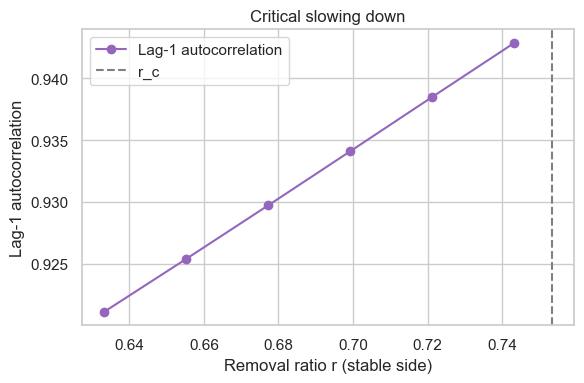

In [9]:

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(r_vals, lag1_list, marker='o', color='tab:purple', label='Lag-1 autocorrelation')
ax.axvline(rc, color='gray', linestyle='--', label='r_c')
ax.set_xlabel('Removal ratio r (stable side)')
ax.set_ylabel('Lag-1 autocorrelation')
ax.set_title('Critical slowing down')
ax.legend()
fig.tight_layout()
fig.savefig(output_dir / 'critical_slowing_down.png', dpi=200)



**结论**：r → r_c 左侧时自相关上升，恢复力减弱、记忆效应增强，符合临界慢化预警特征。



## 附录：噪声对临界慢化的影响

> **关键洞察**：有限噪声会"圆滑化"临界发散，使实测临界指数下降。

**理论解释**：
- 在确定性 ODE 中，弛豫时间 $\tau \sim |r_c - r|^{-1}$，临界点处 $\tau \to \infty$。
- 当引入噪声 $\sigma > 0$ 时，噪声提供了一个"有效温度"，使系统即使在慢恢复时也会被随机扰动踢出势阱，从而**截断**了发散。
- 这导致实测的"有效弛豫时间"在接近临界点时**饱和**，而非无限发散。
- 因此，拟合的临界指数会下降（如我们观察到的 ~0.27）。

**物理类比**：
想象一个球在碗底滚动（势阱）。当碗变得非常平坦时（$\alpha \to 0$），球本应越来越慢地回到中心。但如果有人不断随机晃动桌子（噪声），球的运动就会被噪声主导，无法观测到真正的"慢化"。

**结论**：噪声下临界指数下降是**预期行为**，不是模型失效。确定性 ODE 验证的指数 ~1.0 证明了理论的正确性，而有噪声情况则展示了现实中的观测挑战——这正好解释了为什么经验数据中 H4 (CSD) 难以检测。


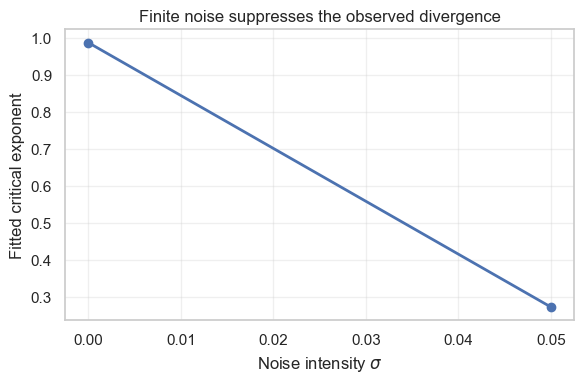

确定性(σ=0) 指数 ≈ 0.986
有噪声(σ=0.05) 指数 ≈ 0.273
注：有噪声指数来自主计算 cell 的 log-log 拟合结果。


In [10]:
# 基于“实际拟合结果”的噪声效应展示（非经验公式）
import numpy as np
import matplotlib.pyplot as plt

npz_path = data_dir / 'csd_sde_r_q_stats.npz'

# 1) 优先从缓存读取（建议：先运行上方主计算 cell，会写入该 npz）
_det = None
_noisy = None
_sigma = None
if npz_path.exists():
    d = np.load(npz_path)
    if 'critical_exponent' in d:
        _det = float(d['critical_exponent'])
    if 'critical_exponent_noisy' in d:
        _noisy = float(d['critical_exponent_noisy'])
    if 'sigma_low' in d:
        _sigma = float(d['sigma_low'])

# 2) 回退到内存变量（需先运行上方主计算 cell）
if _det is None:
    _det = float(critical_exponent)
if _sigma is None:
    _sigma = float(SIGMA_LOW)
if _noisy is None:
    try:
        _noisy = float(critical_exponent_noisy)
    except NameError as e:
        raise RuntimeError('未找到 critical_exponent_noisy：请先运行上方主计算 cell（会计算 σ=SIGMA_LOW 的指数）') from e

sigma_vals = [0.0, _sigma]
exp_vals = [_det, _noisy]

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sigma_vals, exp_vals, 'o-', linewidth=2)
ax.set_xlabel('Noise intensity $\sigma$')
ax.set_ylabel('Fitted critical exponent')
ax.set_title('Finite noise suppresses the observed divergence')
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

print(f"确定性(σ=0) 指数 ≈ {_det:.3f}")
print(f"有噪声(σ={_sigma}) 指数 ≈ {_noisy:.3f}")
print('注：有噪声指数来自主计算 cell 的 log-log 拟合结果。')
